# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
### Basic notebook setup and utilities.


# Whether to run functions that demonstrate parts of the project.
#__demos__ = True
__demos__ = False

class Attributes(object):
    r'''Dynamic collection of named attributes.
    '''
    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [2]:
### Basic dataset manipulation classes.

import pickle
from collections import defaultdict

import numpy as np


class Data(object):
    r'''Base class for single-type data collection classes.
    '''
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

    def extend(self, data):
        self.data = np.concatenate([self.data, data])
    
    @property
    def shape(self):
        return self.data.shape


class Images(Data):
    r'''Collection of RGB images, represented as 3D arrays of unsigned 8-bit integers.
    '''
    def __init__(self, data):
        Data.__init__(self, data)
    
    def image(self, index):
        return self[index]
    
    
class Labels(Data):
    r'''Collection of class labels, represented as integer values.
    '''
    def __init__(self, data, breadth):
        Data.__init__(self, data)
        self.breadth = breadth
        if breadth == None:
            n = range(len(self))
            classes = set(self.classof(i) for i in n)
            self.breadth = len(classes)

    def classof(self, index):
        return self[index]
    
    @property
    def classes(self):
        classes = dict((c, []) for c in range(self.breadth))
        for i in range(len(self)):
            k = self.classof(i)
            classes[k].append(i)
        
        return classes


class Dataset(object):
    r'''A collection of data cases and associated class identifiers.
    '''
    def __init__(self, *args, **kwargs):
        r'''Create a new dataset instance.
        
            Datasets can be loaded from files, for example:
        
                dataset = Dataset('title', 'path/to/pickled_file.p')
            
            They can also be created from other datasets:
            
                dataset = Dataset(other_dataset)
            
            or
            
                dataset = Dataset(title, X, y)
        '''
        if len(args) == 1:
            self.__assign(args[0])
        elif len(args) == 2:
            self.__load(args[0], args[1], kwargs)
        elif len(args) == 3:
            self.title = args[0]
            self.X = args[1]
            self.y = args[2]
        else:
            raise Exception('Invalid argument list: %s' % str(args))

    def __assign(self, dataset):
        self.title = dataset.title
        self.X = dataset.X
        self.y = dataset.y

    def __load(self, title, path, kwargs):
        with open(path, mode='rb') as data:
            self.title = title
            dataset = pickle.load(data)
            self.X = Images(dataset['features'])
            self.y = Labels(dataset['labels'], kwargs.get('breadth'))

    def __len__(self):
        return len(self.X)
    
    def __str__(self):
        template = (
            '%s dataset\n'
            'Number of entries: %d\n'
            'Input shape: %s\n'
            'Output shape: %s\n'
            'Number of classes: %d\n'
        )
        
        return template % (
            self.title,
            len(self),
            str(self.X.shape[1:]),
            str(self.y.shape[1:]),
            self.y.breadth
        )


def Parameters():
    r'''Create a new set of parameters for a neural network training problem.
    '''
    parameters = Attributes()
    parameters.inputs = Attributes()
    parameters.output = Attributes()
    parameters.patch = Attributes()
    parameters.batch = Attributes()
    return parameters


def load_datasets():
    data = Attributes()
    data.train = Dataset('Train', 'datasets/pickled/train.p')
    data.test = Dataset('Test', 'datasets/pickled/test.p', breadth=data.train.y.breadth)
    return data


def print_datasets(data):
    for dataset in vars(data).values():
        print(dataset)

In [3]:
### To start off let's do a basic data summary.
if __demos__ == True:
    print_datasets(load_datasets())

In [4]:
### Data visualization facilities.

import csv
from random import sample

from matplotlib import pyplot as plt
from matplotlib import cm


# Widen the page region used for plots
plt.rcParams['figure.figsize'] = (9.0, 4.0) # Otiginal: (6.0, 4.0)


class Displayer(object):
    def __init__(self, path):
        with open(path) as csv_file:
            csv_data = csv.reader(csv_file)
            next(csv_data) # Discard column title row
            self.labels = dict((int(row[0]), str(row[1])) for row in csv_data)

    def __call__(self, dataset, k=5):
        r'''Display `k` samples of each class from the given dataset.
        '''
        n = len(dataset)

        print('\n\n  %s' % ('-' * 80))
        print('  %s dataset (total %d entries)' % (dataset.title, n))
        print('  %s\n\n' % ('-' * 80))

        labels = self.labels
        classes = dataset.y.classes

        for c in range(len(classes)):
            indexes = classes[c]
            print('  Class %d ("%s", total %d entries) samples:' % (c, labels[c], len(indexes)))
            if len(indexes) >= k:
                s = sample(indexes, k)
                self.display_signs(dataset, s)

    def display_signs(self, dataset, indexes):
        r'''Display the indexed sign images and corresponding labels side by side.
        '''
        n = len(indexes)
        for i in range(n):
            plotter = plt.subplot2grid((1, n), (0, i))
            self.display_sign(plotter, dataset, indexes[i])

        plt.tight_layout()
        plt.show()

    def display_sign(self, plotter, dataset, i):
        r'''Display a sign image and corresponding numeric label.
        '''
        plotter.imshow(dataset.X.image(i))
        plotter.xaxis.set_visible(False)
        plotter.yaxis.set_visible(False)
        plotter.title.set_text(str(i))


display = Displayer('datasets/signnames.csv')


def display_datasets(data):
    display(data.train)
    display(data.test)

In [5]:
### Display summary statistics and samples for the training and test datasets.
if __demos__ == True:
    display_datasets(load_datasets())

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Data preprocessing facilities.

from itertools import product


class Tensors(Images):
    r'''Collection of multi-dimensional vectors.
    '''
    def __init__(self, values):
        Images.__init__(self, values.astype(np.float32))
    
    def image(self, index):
        x = self[index]
        image = np.zeros(x.shape, dtype=np.uint8)
        for d in range(3):
            channel = np.array(x[:, :, d])
            channel -= channel.min()
            channel *= (255.0 / channel.max())
            image[:, :, d] = channel.astype(np.uint8)
        
        return image

    
class Likelihoods(Labels):
    r'''Collection of vectors indicating the likelihoods an input belongs to each of a set of classes.
    '''
    def __init__(self, data, breadth):
        Labels.__init__(self, data, breadth)
        if len(data.shape) == 1:
            self.data = (np.arange(self.breadth) == data[:, None]).astype(np.float32)

    def classof(self, index):
        return np.argmax(self[index])

    
class Vectorized(Dataset):
    r'''A dataset where both inputs and outputs are represented as floating-point arrays.
    '''
    def __init__(self, *args, **kwargs):
        Dataset.__init__(self, *args, **kwargs)
        self.X = Tensors(self.X.data)
        self.y = Likelihoods(self.y.data, self.y.breadth)


class Normalized(Dataset):
    def __init__(self, *args, **kwargs):
        Dataset.__init__(self, *args, **kwargs)

        X = self.X
        n = X.shape[0]
        d = X.shape[-1]
        for (i, j) in product(range(n), range(d)):
            channel = X[i, :, :, j]
            channel -= channel.mean()
            channel /= channel.std()


def load_preprocessed():
    data = load_datasets()
    data.train = Normalized(Vectorized(data.train))
    data.test = Normalized(Vectorized(data.test))
    return data

In [7]:
# Preprocess training and test datasets.
if __demos__ == True:
    print_datasets(load_preprocessed())

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In order to ensure numeric stability and make the associated optimizaton problem well-conditioned [[^](https://www.youtube.com/watch?v=0mxNQA95mYE)], inputs are normalized to zero mean and unit standard deviation. This is done simply by converting images to floating-point multidimensional arrays and then normalizing each channel separately. Outputs are also preprocessed here, converted from integer label indicators to one hot-encoded vectors, for use later on training.

In [8]:
### Separate a validation subset from the training dataset.

from random import choice, triangular

from scipy.misc import imrotate
from sklearn.cross_validation import train_test_split


class Culled(Dataset):
    r'''A dataset where classes are culled down to a common size.
    '''
    def __init__(self, *args, **kwargs):
        Dataset.__init__(self, *args, **kwargs)
        classes = self.y.classes.values()
        n_min = np.min([len(cases) for cases in classes])
        X = self.X
        y = self.y
        
        X_cull = []
        y_cull = []
        for cases in classes:
            for k in sample(cases, n_min):
                X_cull.append(X[k])
                y_cull.append(y[k])
                
        X.data = np.array(X_cull)
        y.data = np.array(y_cull)


def logistic(x, x0, k, l):
    return l / (1.0 + np.exp(-k * (x - x0)))


def jiggle(data, r_l = 2.0, r_roll=5, r_degs=10):
    r'''Perform slight changes to the input array.
    
        Input images are randomly multiplied by a brightness mask,
        rolled around the horizontal and vertical axes, and rotated.
    '''
    shape = data.shape[:2]
    (m, n) = shape

    xr = int(triangular(-r_roll, r_roll))
    yr = int(triangular(-r_roll, r_roll))

    (x, y) = np.indices(shape)
    x0 = triangular(0, n - 1)
    y0 = triangular(0, m - 1)

    l = ((x - x0) ** 2.0 + (y - y0) ** 2.0) ** 0.5
    l -= triangular(0, l.max())
    l *= choice([-1, 1])
    l = logistic(l, 0, 0.1, r_l) + (1.0 / r_l)
    l = np.dstack([l, l, l])
        
    degs = triangular(-r_degs, r_degs)

    data *= l
    data = np.roll(data, yr, axis=0)
    data = np.roll(data, xr, axis=1)
    data = imrotate(data, degs)
    return data


def padding(dataset, **kwargs):
    r'''Generate a dataset with randomly modified data items from the source dataset.
    
        Items are generated in inverse class distribution relative to the source dataset,
        so that no items are generated for the most numerous class, and the least numerous
        is given the most items.
    '''
    classes = dataset.y.classes.values()
    n_max = np.max([len(cases) for cases in classes])
    X = dataset.X
    y = dataset.y

    X_extra = []
    y_extra = []
    for cases in classes:
        n = len(cases)
        for i in range(n_max - n):
            k = choice(cases)
            X_extra.append(jiggle(X[k], **kwargs))
            y_extra.append(y[k])

            
    DataX = X.__class__
    DataY = y.__class__
    breadth = dataset.y.breadth
    
    return Dataset('Padding', DataX(np.array(X_extra)), DataY(np.array(y_extra), breadth))


class Padded(Dataset):
    r'''A dataset where all classes are guaranteed to have the same case count.
    
        If some classes in the original dataset contain more cases than others,
        extra cases are generated through random transformations, until all
        classes have the same number of cases.
    '''
    def __init__(self, *args, **kwargs):
        Dataset.__init__(self, *args, **kwargs)
        classes = self.y.classes.values()
        n_max = np.max([len(cases) for cases in classes])
        X = self.X
        y = self.y
        
        X_extra = []
        y_extra = []
        for cases in classes:
            n = len(cases)
            for i in range(n_max - n):
                k = choice(cases)
                X_extra.append(jiggle(X[k], **kwargs))
                y_extra.append(y[k])
                
        self.X.extend(X_extra)
        self.y.extend(y_extra)


def split(dataset, rate=0.3):
    X = dataset.X
    y = dataset.y
    
    DataX = X.__class__
    DataY = y.__class__

    (X_train, X_valid, y_train, y_valid) = train_test_split(
        X.data,
        y.data,
        test_size=rate,
        random_state=832289
    )
    
    breadth = dataset.y.breadth
    return (
        Dataset('Train', DataX(X_train), DataY(y_train, breadth)),
        Dataset('Validate', DataX(X_valid), DataY(y_valid, breadth))
    )


def split_padded_train(data):
    (data.train, data.valid) = split(Padded(data.train))
    return data

In [9]:
if __demos__ == True:
    print_datasets(split_padded_train(load_preprocessed()))
    display(padding(load_preprocessed().train))

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf


def weights(*shape):
    return tf.Variable(tf.truncated_normal(list(shape), stddev=0.1))


def bias(b, n):
    return tf.Variable(tf.constant(b, shape=[n]))


def layer_depth(layer):
    return layer.get_shape().as_list()[-1]


def layer_2d(layer):
    shape = layer.get_shape()
    shape = [-1, shape[1:].num_elements()]
    return tf.reshape(layer, shape)


def layer_connected(layer, b, n):
    m = layer_depth(layer)
    return tf.matmul(layer, weights(m, n)) + bias(b, n)


def layer_convolved(layer, side, depth, stride=1, padding='SAME', b=None):
    strides = [1, stride, stride, 1]
    W = weights(side, side, layer_depth(layer), depth)
    C = tf.nn.conv2d(layer, W, strides, padding)
    B = weights(depth) if b == None else bias(b, depth)
    return C + B


# Architecture and parameters taken from:
# https://hackathonprojects.wordpress.com/2016/09/25/inception-modules-explained-and-implemented/
def inception_module(inputs, depth_1x1, depth_out):
    def conv_1x1(layer=inputs, depth=depth_out):
        return layer_convolved(layer, 1, depth)
    
    def conv_3x3():
        reduced = tf.nn.relu(conv_1x1(inputs, depth_1x1))
        return layer_convolved(reduced, 3, depth_out)
    
    def conv_5x5():
        reduced = tf.nn.relu(conv_1x1(inputs, depth_1x1))
        return layer_convolved(reduced, 5, depth_out)
    
    def max_pool():
        pooled = tf.nn.max_pool(inputs, [1, 3, 3, 1], [1, 1, 1, 1], 'SAME')
        return conv_1x1(pooled, depth_out)

    return tf.nn.relu(tf.concat(3, [conv_1x1(), conv_3x3(), conv_5x5(), max_pool()]))
    

class Network(object):
    def __init__(self, parameters):
        l_input = parameters.inputs.side
        d_input = parameters.inputs.depth
        d_patch = parameters.patch.depth
        n_hidden = parameters.hidden_nodes
        n_classes = parameters.output.classes
        
        with tf.Graph().as_default(): # ensures variable names are consistent across network instances
            self.inputs = tf.placeholder(tf.float32, shape=(None, l_input, l_input, d_input))

            layer = inception_module(self.inputs, d_patch // 2, d_patch)
            layer = inception_module(layer, d_patch // 2, d_patch)
            layer = layer_connected(layer_2d(layer), 1.0, n_hidden)
            layer = layer_connected(tf.nn.relu(layer), 1.0, n_classes)

            self.outputs = layer
            self.argmax = tf.argmax(layer, 1)
            self.session = tf.Session()

    def __call__(self, X):
        return self.session.run(self.argmax, feed_dict={self.inputs: X})
    
    def init_variables(self):
        with self.session.graph.as_default():
            init = tf.initialize_all_variables()
            self.session.run(init)            

    
def default_parameters():
    parameters = Parameters()
    parameters.inputs.side = 32
    parameters.inputs.depth = 3
    parameters.output.classes = 43
    parameters.patch.side = 5
    #parameters.patch.depth = 32
    parameters.patch.depth = 6
    parameters.hidden_nodes = 64
    parameters.batch.size = 50
    parameters.batch.step = 10
    parameters.learning_rate = 0.1
    #parameters.learning_rate = 1e-4
    parameters.epochs = 5
    return parameters


def default_network():
    return Network(default_parameters())

In [11]:
if __demos__ == True:
    default_network()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [22]:
### Train your model here.
### Feel free to use as many code cells as needed.

from math import ceil, floor
from sys import maxsize

from tqdm import tqdm


def batches(dataset, l, counter=range):
    X = dataset.X
    y = dataset.y
    n = int(ceil(len(X) / l)) # Ensures a final "rest" batch will be issued as appropriate
    for k in counter(n):
        a = k * l
        b = a + l
        yield (k, X[a:b], y[a:b])


class Accuracy(object):
    def __init__(self, network, batch_size, *datasets):
        self.inputs = network.inputs
        self.session = network.session
        with network.session.graph.as_default():
            self.outputs = tf.placeholder(tf.float32)
            is_correct_prediction = tf.equal(network.argmax, tf.argmax(self.outputs, 1))
            self.accuracy = tf.reduce_sum(tf.cast(is_correct_prediction, tf.float32))

        self.datasets = datasets
        self.batch_size = batch_size

    def __call__(self):
        def accuracy(dataset):
            total = 0.0
            count = 0.0
            for (k, X_k, y_k) in batches(dataset, self.batch_size):
                data = {self.inputs: X_k, self.outputs: y_k}
                total += self.session.run(self.accuracy, feed_dict=data)
                count += len(X_k)

            return total / count

        return tuple(accuracy(dataset) for dataset in self.datasets)


class Optimizer(object):
    def __init__(self, network, learning_rate):
        self.inputs = network.inputs
        self.session = network.session
        with self.session.graph.as_default():
            self.outputs = tf.placeholder(tf.float32)
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(network.outputs, self.outputs)
            self.loss = tf.reduce_mean(cross_entropy)
            # TODO: try different optimizer
            # https://www.tensorflow.org/versions/r0.11/api_docs/python/train.html#AdamOptimizer
            #self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
            self.optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=0.1).minimize(self.loss)
            
    def __call__(self, X, y):
        data = {self.inputs: X, self.outputs: y}
        (_, l) = self.session.run([self.optimizer, self.loss], feed_dict=data)
        return l


def plot_lines(title, x, *ys, **kwargs):
    y_min = maxsize
    y_max = -maxsize

    plotter = plt.subplot(111)
    for (y, c, l) in ys:
        label = '%s (last: %.3f)' % (l, round(y[-1], 3))
        plotter.plot(x, y, c, label=label)
        y_min = min(floor(np.min(y)), y_min)
        y_max = max(ceil(np.max(y)), y_max)

    plotter.set_title(title)
    plotter.set_xlim([x[0], x[-1]])
    plotter.set_ylim([y_min, y_max])
    plotter.legend(loc=kwargs.get('loc', 1))
    plt.tight_layout()
    plt.show()


def train(network, data, parameters):
    batch_size = parameters.batch.size
    batch_step = parameters.batch.step
    learning_rate = parameters.learning_rate
    epochs = parameters.epochs

    accuracy = Accuracy(network, parameters.batch.size, data.train, data.valid)
    optimizer = Optimizer(network, learning_rate)
    session = network.session

    x_batch = []
    y_train = []
    y_valid = []
    y_loss = []
    
    network.init_variables()
    
    for i in range(epochs):
        counter = lambda n: tqdm(range(n), desc='Epoch {:>2}/{}'.format(i + 1, epochs), unit='batches')
        for (k, X_k, y_k) in batches(data.train, batch_size, counter):
            loss = optimizer(X_k, y_k)

            if k % batch_step == 0:
                (a_train, a_valid) = accuracy()
                x_batch.append(len(x_batch) * batch_step)
                y_train.append(a_train)
                y_valid.append(a_valid)
                y_loss.append(loss)

        plot_lines('Loss', x_batch,
            (y_loss, 'g', 'Loss')
        )

        plot_lines('Accuracy', x_batch,
            (y_train, 'r', 'Training Accuracy'),
            (y_valid, 'b', 'Validation Accuracy'),
            loc=4
        )


def load(network, path):
    session = network.session
    with session.graph.as_default():
        saver = tf.train.Saver()
        saver.restore(session, path)


def save(network, path):
    session = network.session
    with session.graph.as_default():
        saver = tf.train.Saver()
        saver.save(session, path)


def trained_network():
    data = Attributes()
    #data.train = Normalized(Padded(Vectorized('Train', 'datasets/pickled/train.p')))
    #data.train = Normalized(Culled(Vectorized('Train', 'datasets/pickled/train.p')))
    data.train = Normalized(Vectorized('Train', 'datasets/pickled/train.p'))
    (data.train, data.valid) = split(data.train)

    parameters = default_parameters()
    parameters.inputs.side = data.train.X.shape[1]
    parameters.output.classes = data.train.y.breadth

    network = Network(parameters)
    train(network, data, parameters)
    save(network, 'network.chk')

    return network

Epoch  1/5: 100%|██████████| 549/549 [07:33<00:00,  2.29batches/s]


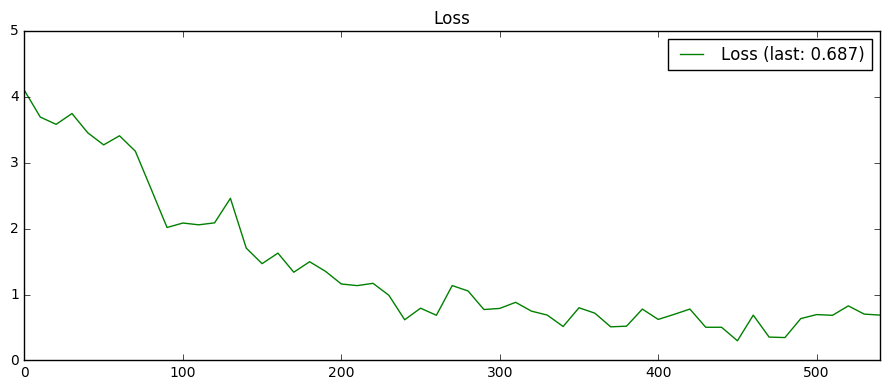

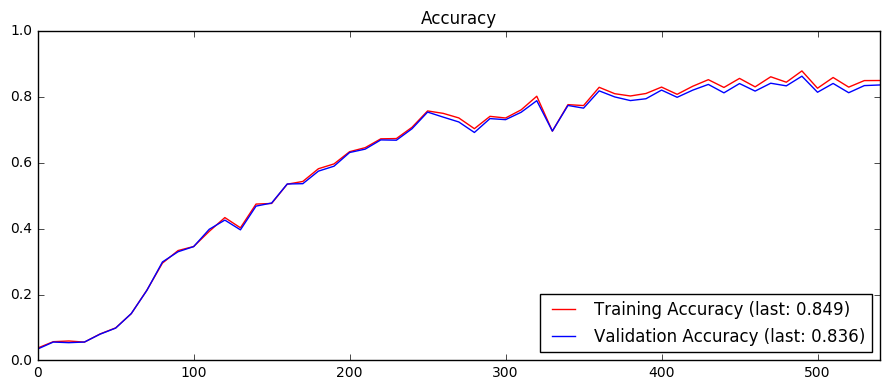

Epoch  2/5: 100%|██████████| 549/549 [07:50<00:00,  2.61batches/s]


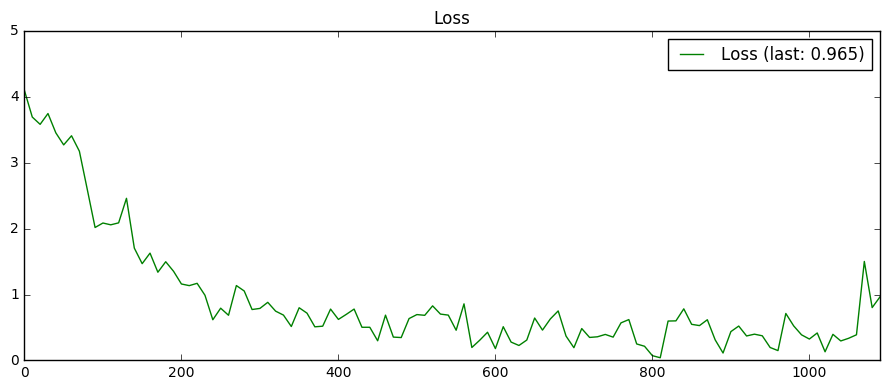

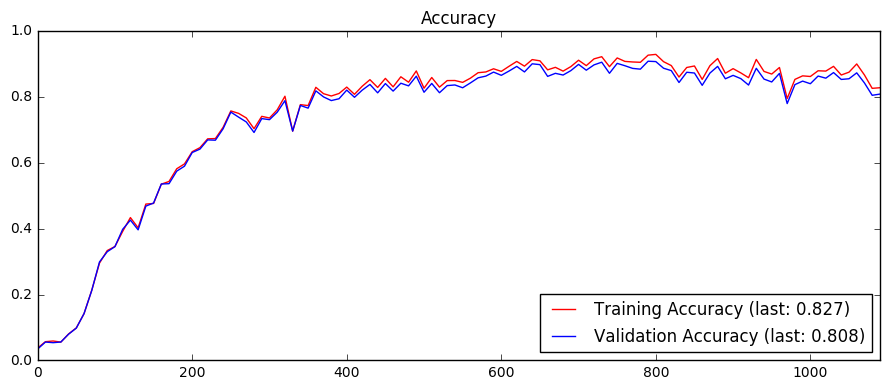

Epoch  3/5:   3%|▎         | 19/549 [00:16<05:38,  1.57batches/s]


KeyboardInterrupt: 

In [23]:
network = trained_network()

In [ ]:
network2 = Network(default_parameters())
load(network2, 'inception.chk')

data_train = Normalized(Culled(Vectorized('Train', 'datasets/pickled/train.p')))

print(network2(data_train.X[:1]), data_train.y.classof(0))

#test = Preprocessed('Test', 'datasets/pickled/test.p')

#accuracy = Accuracy(network, 50, test)
#print('Test performance: %.3f' % round(accuracy()[0], 3))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.